# Average Bubble

In [1]:
import os,sys
sys.path.append('./bubbles_codes/')
from bubble_tools import *
from experiment import *
from plotting import *

In [26]:
get_vels     = True
get_avBubble = True
savef        = True
plots        = False


In [27]:
if False:
    for tmp, temp in enumerate(tempList):
        if tmp>1: continue

        if tmp == 0: minSim, maxSim = 0, 2500
        elif tmp == 1: minSim, maxSim = 0, 3000
        elif tmp == 2: minSim, maxSim = 0, 2000
        elif tmp == 3: minSim, maxSim = 0, 2800

        lamb=lambList[tmp]
        sigmafld=fluct_stdev(lamb, phi0, temp)
        print('Looking at at lambda, T, phi0, m2, sigma:', lamb, temp, phi0, m2(lamb), sigmafld)

        ### Useful
        right_Vmax  = sco.minimize_scalar(Vinv, args=lamb, bounds=(np.pi, 2*np.pi), method='bounded')
        left_Vmax   = sco.minimize_scalar(Vinv, args=lamb, bounds=(0    ,   np.pi), method='bounded')
        crit_thresh = right_Vmax.x+2.*sigmafld

        win = 300
        critSize = 20

        if get_vels:
            all_vels = []
            for sim in range(minSim, maxSim):
                path_clean_sim = clean_sim_location(nLat, lamb, phi0, temp, sim)
                loc_rest_bub = bubble_at_rest(nLat, lamb, phi0, temp, sim)+'.npy'
                if os.path.exists(loc_rest_bub):
                    sim, real, totalvCOM, finalv = np.load(loc_rest_bub)
                    all_vels.append(np.asarray([sim, totalvCOM]))
            print('Total bubbles included:', len(all_vels))

            if savef:
                np.save(velocities_bubbles_file(nLat, lamb, phi0, temp), np.asarray(all_vels))
                print('Velocities saved.')

        if get_avBubble:
            all_data = []
            for sim in range(minSim, maxSim):      
                path_clean_sim = clean_sim_location(nLat, lamb, phi0, temp, sim)
                loc_rest_bub = bubble_at_rest(nLat, lamb, phi0, temp, sim)+'.npy'
                if os.path.exists(loc_rest_bub):
                    sim, real, totalvCOM, finalv = np.load(loc_rest_bub)
                    if np.abs(totalvCOM) < 0.89:
                        all_data.append(np.asarray([real, totalvCOM, sim]))

            print('Total bubbles included:', len(all_data))
            stacks  = stack_bubbles(all_data, plots, win, phieq, crit_thresh, critSize)
            stacks  = average_stacks(stacks, plots, normal)
            avstack = average_bubble_stacks(stacks)

            if savef:
                np.save(average_bubble_file(nLat, lamb, phi0, temp), avstack)
                print('Average bubble saved.')


In [28]:
# Little script to figure out which averaging gives minimum variance in the field.
if False:
    if False:
        minSim = 0
        maxSim = 2000

        tmp = 0
        temp = tempList[tmp]

        lamb=lambList[tmp]
        sigmafld=fluct_stdev(lamb, phi0, temp)

        all_data = []
        for sim in range(minSim, maxSim):      
            path_clean_sim = clean_sim_location(nLat, lamb, phi0, temp, sim)
            loc_rest_bub = bubble_at_rest(nLat, lamb, phi0, temp, sim)+'.npy'
            if os.path.exists(loc_rest_bub):
                sim, real, totalvCOM, finalv = np.load(loc_rest_bub)
                all_data.append(np.asarray([real, totalvCOM, sim]))

    critSizeList  = np.array(np.arange(18, 23, 2), dtype='int'); print(critSizeList)

    right_Vmax  = sco.minimize_scalar(Vinv, args=lamb, bounds=(np.pi, 2*np.pi), method='bounded')
    left_Vmax   = sco.minimize_scalar(Vinv, args=lamb, bounds=(0    ,   np.pi), method='bounded')
    threshList  = [right_Vmax.x+0.25*sigmafld, right_Vmax.x+0.5*sigmafld, right_Vmax.x+0.75*sigmafld, right_Vmax.x+3.*sigmafld]
    
    win = 80

    if True:
        for cind, ct in enumerate(critSizeList):
            for tind, tsh in enumerate(threshList):
                try:
                    stacks  = stack_bubbles(all_data, plots, win, phieq, tsh, ct)
                    stacks  = average_stacks(stacks, plots, normal)
                    avstack = average_bubble_stacks(stacks)

                    np.save(average_bubble_file(nLat, lamb, phi0, temp)+'prelimCS'+str(ct)+'prelimTS'+str(tsh), avstack)
                    print('Done', cind, tind)
                except:
                    continue
        print('Done averaging.')

    bubbleList = np.zeros((len(critSizeList), len(threshList), 2, 3, 2*win+1, 2*win+1))
    for cind, ct in enumerate(critSizeList):
        for tind, tsh in enumerate(threshList):
            bubbleList[cind, tind] = np.load(average_bubble_file(nLat, lamb, phi0, temp)+'prelimCS'+str(ct)+'prelimTS'+str(tsh)+'.npy')

    tp = 1 # 0 for average, 1 for error
    cp = 0 # 0 - field, 1 - momentum, 2 - gradient

    varmat = np.zeros((len(critSizeList), len(threshList)))
    for cind, ct in enumerate(critSizeList):
        for tind, tsh in enumerate(threshList):
            varmat[cind, tind] = np.mean(bubbleList[cind][tind][tp,cp, win//2:-win//2, win//2:-win//2])

    fig, ax = plt.subplots(1,1, figsize = (5,4))
    ext  = [threshList[0], threshList[-1], critSizeList[0], critSizeList[-1]]
    im0  = plt.imshow(varmat, interpolation='none', extent=ext, aspect='auto', origin='lower')
    clb0 = plt.colorbar(im0, ax = ax)

    tp = 0 # 0 for average, 1 for error

    fig, ax = plt.subplots(len(critSizeList), len(threshList), figsize = (len(threshList)*5, len(critSizeList)*5))
    for cind, ct in enumerate(critSizeList):
        for tind, tsh in enumerate(threshList):
            try:
                average_bubble = bubbleList[cind][tind]
                bubble = average_bubble[0,0]
                nT, nN = np.shape(bubble)
                tcen, xcen  = find_nucleation_center2(bubble, phieq, tsh, ct)
                tl, tr      = max(0, tcen-win//2), min(nT-1, tcen+win//2)
                xl, xr      = max(0, xcen-win//2), min(nN-1, xcen+win//2)
                ext         = np.asarray([(-xcen), (nN-xcen), (-tcen), (nT-tcen)])*dx2plot
                bubble2plot = average_bubble[tp,cp][tl:tr,xl:xr]
            except:
                average_bubble = np.ones((200, 200))
                bubble2plot = average_bubble

       #     bubble2plot = average_bubble[tp,cp][tl:tr,xl:xr]*100
            im0  = ax[cind,tind].imshow(bubble2plot, interpolation='none', extent=ext, origin='lower', cmap='tab20b')
            clb0 = plt.colorbar(im0, ax = ax[cind,tind])
            ax[cind,tind].plot(0, 0, color='c', marker='*', ms='5', label='size='+str(ct)+', thresh='+str(format(tsh, '1.2f')))
            ax[cind,tind].legend(title=r'$T=$'+str(temp), loc=4, fontsize='small', fancybox=True, frameon=True, framealpha=0.75, borderpad=0.3)
    plt.show()

[0.00112556 0.00294873]


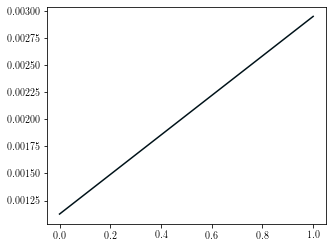

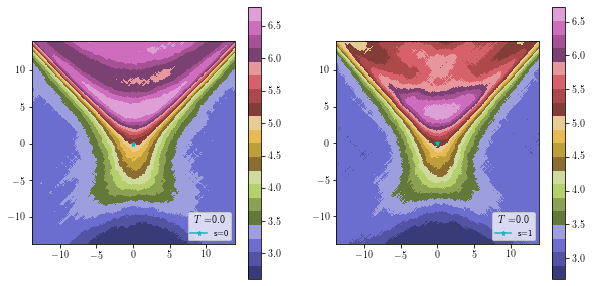

199 200 [179 192 199 205 219]
200 200 [180 193 200 206 220]
199 200 [179 192 199 205 219]
200 200 [180 193 200 206 220]


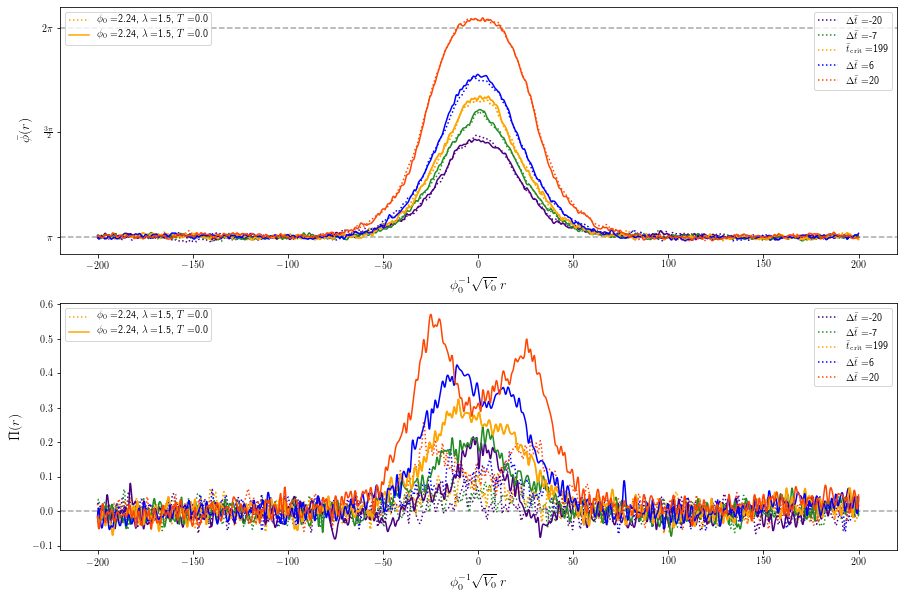

In [29]:
# Little script to produce bubbles of same field kind, but difference velocity brackets
minSim = 0
maxSim = 2500

tmp = 0
temp = tempList[tmp]

lamb=lambList[tmp]
sigmafld=fluct_stdev(lamb, phi0, temp)

if False:
    all_data = []
    for sim in range(minSim, maxSim):      
        path_clean_sim = clean_sim_location(nLat, lamb, phi0, temp, sim)
        loc_rest_bub = bubble_at_rest(nLat, lamb, phi0, temp, sim)+'.npy'
        if os.path.exists(loc_rest_bub):
            sim, real, totalvCOM, finalv = np.load(loc_rest_bub)
            all_data.append(np.asarray([real, totalvCOM, sim]))
    veldata = np.load(velocities_bubbles_file(nLat, lamb, phi0, temp)+'.npy')
    simvels, all_vels = veldata[:,0], veldata[:,1]
    print('Number of bubbles, temperature:', len(all_vels), temp)

if True:
    velsplit = 0.89

    a1=np.argwhere(np.abs(all_vels) <= velsplit).flatten()
    a2=np.argwhere(np.abs(all_vels) > velsplit).flatten()
    a3=np.sort(np.concatenate((a1,a2)))
    a4=np.array(simvels[a1], dtype='int')
    a5=np.array(simvels[a2], dtype='int')
    a6=np.sort(np.concatenate((a4,a5)))
    simindlist = [a1, a2]
    simlist = [a4, a5]
    #print(len(all_data), len(a1), len(a2), len(a3))
    
    right_Vmax  = sco.minimize_scalar(Vinv, args=lamb, bounds=(np.pi, 2*np.pi), method='bounded')
    left_Vmax   = sco.minimize_scalar(Vinv, args=lamb, bounds=(0    ,   np.pi), method='bounded')
    crit_thresh = right_Vmax.x+2.*sigmafld

    win = 200
    critSize = 20

    if False:
        for stype, (simi, simt) in enumerate(zip(simindlist, simlist)):
            part_data = np.array([all_data[i] for i in simi])
            stacks  = stack_bubbles(part_data, plots, win, phieq, crit_thresh, critSize)
            stacks  = average_stacks(stacks, plots, normal)
            avstack = average_bubble_stacks(stacks)

            np.save(average_bubble_file(nLat, lamb, phi0, temp)+'stype'+str(stype)+'velsplit'+str(velsplit), avstack)
            print('Done', stype, simi)

    bubbleList = np.zeros((len(simlist), 2, 3, 2*win+1, 2*win+1))
    for stype, (simi, simt) in enumerate(zip(simindlist, simlist)):
        bubbleList[stype] = np.load(average_bubble_file(nLat, lamb, phi0, temp)+'stype'+str(stype)+'velsplit'+str(velsplit)+'.npy')

    tp = 1 # 0 for average, 1 for error
    cp = 0 # 0 - field, 1 - momentum, 2 - gradient

    varmat = np.zeros((len(simlist)))
    for stype, (simi, simt) in enumerate(zip(simindlist, simlist)):
        varmat[stype] = np.mean(bubbleList[stype][tp,cp, win//2:-win//2, win//2:-win//2])
    print(varmat)

    fig, ax = plt.subplots(1,1, figsize = (5,4))
    plt.plot(np.arange(len(simlist)), varmat); plt.show()

    tp = 0 # 0 for average, 1 for error

    fig, ax = plt.subplots(1, 2, figsize = (len(simlist)*5, 5))
    for stype, simi in enumerate(simindlist):
        average_bubble = bubbleList[stype]
        bubble = average_bubble[0,0]
        nT, nN = np.shape(bubble)
        tcen, xcen  = find_nucleation_center2(bubble, phieq, crit_thresh, critSize)
        tl, tr      = max(0, tcen-win//2), min(nT-1, tcen+win//2)
        xl, xr      = max(0, xcen-win//2), min(nN-1, xcen+win//2)
        ext         = np.asarray([(-xcen), (nN-xcen), (-tcen), (nT-tcen)])*dx2plot
        bubble2plot = average_bubble[tp,cp][tl:tr,xl:xr]

        im0  = ax[stype].imshow(bubble2plot, interpolation='none', extent=ext, origin='lower', cmap='tab20b')
        clb0 = plt.colorbar(im0, ax = ax[stype])
        ax[stype].plot(0, 0, color='c', marker='*', ms='5', label='s='+str(stype))
        ax[stype].legend(title=r'$T=$'+str(temp), loc=4, fontsize='small', fancybox=True, frameon=True, framealpha=0.75, borderpad=0.3)
    plt.show()
    
    fig, ax = plt.subplots(2, 1, figsize = (15, 10))
    ax[1].axhline(0., color='darkgray', ls='--')
    ax[0].axhline(phieq, color='darkgray', ls='--')
    ax[0].axhline(2.*np.pi, color='darkgray', ls='--') 
    ax[0].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax[0].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

    for coln in [0, 1]:
        bool = True
        secondary_lines, secondary_labels = [], []
        for stype, simi in enumerate(simindlist):        
            average_bubble = bubbleList[stype]
            bubble = average_bubble[0,0]
            nT, nN = np.shape(bubble)
            tcen, xcen  = find_nucleation_center2(bubble, phieq, crit_thresh, critSize)
            tl, tr      = max(0, tcen-win), min(nT-1, tcen+win)
            xl, xr      = max(0, xcen-win), min(nN-1, xcen+win)
            ext         = np.asarray([(-xcen), (nN-xcen), (-tcen), (nT-tcen)])*dx2plot
            bubble2plot = average_bubble[0,coln][tl:tr,xl:xr]
            nT, nN = np.shape(bubble2plot)

            timesList = np.array(np.sort(np.linspace(tcen-20, tcen+20, 4).tolist()+[tcen]), dtype='int')
            print(tcen, xcen, timesList)

            cols = cycle(['indigo', 'forestgreen', 'orange', 'blue', 'orangered'])
            labs = r'$\phi_0=$'+str('%.2f'%phi0)+r', $\lambda=$'+str(lamb)+r', $T=$'+str(temp)
            lsl = ('-' if stype==1 else ':')
            for tt in timesList:
                col = next(cols)
                data  = bubble2plot[tt]
                xlist = np.linspace(-xcen, nN-xcen, len(data))

                spline  = scp.interpolate.splrep(xlist, data)
                r       = np.linspace(xlist[0], xlist[-1], 2000)
                profile = scp.interpolate.splev(r, spline)

                if tt == tcen:
                    secondary_labels.append(labs)
                    l1, = ax[coln].plot(r, profile, color=col, ls=lsl)
                    secondary_lines.append(l1)

                if bool:
                    ax[coln].plot(r, profile, color=col, ls=lsl, label=(r'$\Delta \bar{t} = $'+str(tt-tcen) if tt!=tcen else r'$\bar{t}_{\rm crit} = $'+str(tt)))
                else:
                    ax[coln].plot(r, profile, color=col, ls=lsl)

            bool = False
        ax[coln].add_artist(ax[coln].legend(secondary_lines, secondary_labels, loc=2))

    ax[0].set_ylabel(r'$\bar{\phi}(r)$')
    ax[1].set_ylabel(r'$\bar{\Pi}(r)$')
    for axx in ax.flatten():
        axx.set_xlabel(r'$\phi_0^{-1} \sqrt{V_0} \; r$')
        axx.legend(loc=1)
        axx.grid(False)
    plt.show()


In [30]:
bubbleList, instantonList, tmpLoaded, indList, eCritList = [], [], [], [], []
for tmp, temp in enumerate(tempList):
    lamb     = lambList[tmp]
    sigmafld = fluct_stdev(lamb, phi0, temp)
    pathavbub = average_bubble_file(nLat, lamb, phi0, temp)+'.npy'
    bubbleList.append(np.load(pathavbub))

    instantonList.append(np.load(path_inst(nLat, lamb, phi0, temp)+'.npy'))

    tmpLoaded.append(tmp)

    indList.append(np.load(path_indcrit(nLat, lamb, phi0, temp)+'.npy'))
    eCritList.append(np.load(path_encrit(nLat, lamb, phi0, temp)+'.npy'))    

No handles with labels found to put in legend.
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


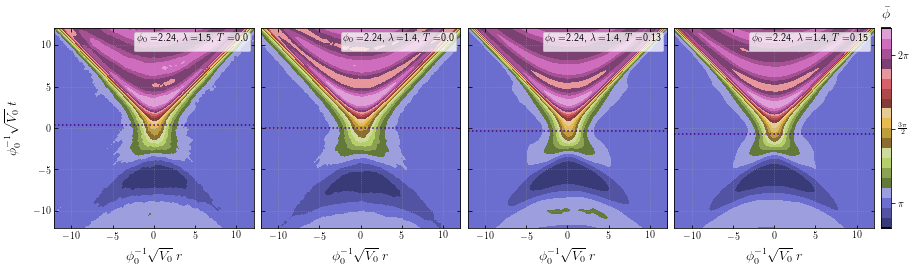

No handles with labels found to put in legend.
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


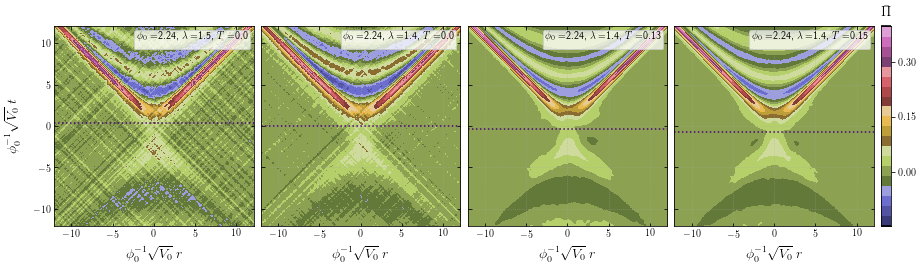

In [31]:
tp = 0# 0 for average, 1 for error

titl = [r'$\bar{\phi}$',  r'$\bar{\Pi}$', r'$\partial_x\bar{\phi}$']
for cp in range(2): # 0 - field, 1 - momentum, 2 - gradient
    
    if cp==0: valmin, valmax = phieq, phieq
    else: valmin, valmax = 0.1, 0.1

    fig = plt.figure(figsize = (15, 5))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, len(bubbleList)), share_all=True, axes_pad=0.1, cbar_location="right", cbar_mode="single")
    im = [[]]*len(bubbleList)
    for ii, average_bubble in enumerate(bubbleList):
        tmp = tmpLoaded[ii]
        temp = tempList[tmp]
        lamb = lambList[tmp]

        phieq     = np.pi
        sigmafld  = fluct_stdev(lamb, phi0, temp)
        win = 175
        critSize = 30/2.

        ### Useful
        right_Vmax  = sco.minimize_scalar(Vinv, args=lamb, bounds=(np.pi, 2*np.pi), method='bounded')
        left_Vmax   = sco.minimize_scalar(Vinv, args=lamb, bounds=(0    ,   np.pi), method='bounded')
        crit_thresh = right_Vmax.x+2.*sigmafld

        nT, nN = np.shape(average_bubble[0,0])
        tcen, xcen  = find_nucleation_center2(average_bubble[0,0], phieq, crit_thresh, critSize)
        if temp==0: tcen-=12
        tl, tr      = max(0, tcen-win), min(nT-1, tcen+win)
        xl, xr      = max(0, xcen-win), min(nN-1, xcen+win)

        bubble2plot = average_bubble[tp,cp]
        bubble2plot = bubble2plot[tl:tr,xl:xr]

        bubble2measure = average_bubble[0,0][tl:tr,xl:xr]
        nT, nN = np.shape(bubble2measure)
        tcen, xcen = find_nucleation_center2(bubble2measure, phieq, crit_thresh, critSize)
        if temp==0: tcen-=12
        ext  = np.asarray([(-xcen), (nN-xcen), (-tcen), (nT-tcen)])*dx2plot

        if np.amin(bubble2plot) < valmin: valmin = np.amin(bubble2plot)
        if np.amax(bubble2plot) > valmax: valmax, maxable = np.amax(bubble2plot), ii

        labs = r'$\phi_0=$'+str('%.2f'%phi0)+r', $\lambda=$'+str(lamb)+r', $T=$'+str(temp)
        lsl = ('-' if tmp==0 else '--' if tmp==1 else ':')

        grid[ii].legend(title=labs, loc=1, fontsize='small', fancybox=True, frameon=True, framealpha=0.75, borderpad=0.3)
        im[ii] = grid[ii].imshow(bubble2plot, interpolation='Gaussian', extent=ext, origin='lower', cmap='tab20b')
        if cp==0:
            cbar = grid[ii].cax.colorbar(im[maxable], ticks=matplotlib.ticker.MultipleLocator(np.pi/2),\
                                                    format=matplotlib.ticker.FuncFormatter(multiple_formatter()))
        else:
            cbar = grid[ii].cax.colorbar(im[maxable])
        grid[ii].cax.toggle_label(True)
        grid[ii].cax.set_title(titl[cp])
        im[ii].set_clim(vmin=valmin, vmax=valmax)
        grid[ii].tick_params(direction='in', which='both', top=True, right=True)
        grid[ii].set(xlabel=r'$\phi_0^{-1} \sqrt{V_0} \; r$')
        
        indmin = int(indList[ii])
        grid[ii].axhline((indmin-tl+1-tcen)*dx2plot, ls=':', color='indigo')
        
        grid[ii].grid(ls=':', color='darkgray', alpha=0.5)
        grid[0].set(ylabel=r'$\phi_0^{-1} \sqrt{V_0} \; t$')
    plt.savefig('./data/average_vacuum_bubble_comparison_'+str(cp)+'.pdf')
    plt.show()


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'


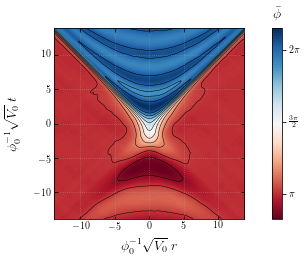

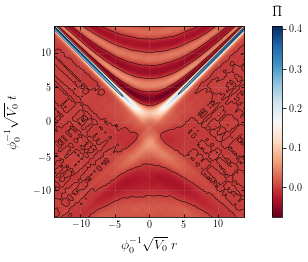

In [32]:
tp = 0# 0 for average, 1 for error

titl = [r'$\bar{\phi}$',  r'$\bar{\Pi}$', r'$\partial_x\bar{\phi}$']
for cp in range(2): # 0 - field, 1 - momentum, 2 - gradient
    
    if cp==0: valmin, valmax = phieq, phieq
    else: valmin, valmax = 0.1, 0.1

    average_bubble = bubbleList[2]

    fig, ax = plt.subplots(1, 1, figsize = (10, 3.5))

    tmp = tmpLoaded[0]
    temp = tempList[tmp]
    lamb = lambList[tmp]

    phieq     = np.pi
    sigmafld  = fluct_stdev(lamb, phi0, temp)
    win = 200
    critSize = 30/2.

    ### Useful
    right_Vmax  = sco.minimize_scalar(Vinv, args=lamb, bounds=(np.pi, 2*np.pi), method='bounded')
    left_Vmax   = sco.minimize_scalar(Vinv, args=lamb, bounds=(0    ,   np.pi), method='bounded')
    crit_thresh = right_Vmax.x+2.*sigmafld

    nT, nN = np.shape(average_bubble[0,0])
    tcen, xcen  = find_nucleation_center2(average_bubble[0,0], phieq, crit_thresh, critSize)
    tcen+=0
    tl, tr      = max(0, tcen-win), min(nT-1, tcen+win)
    xl, xr      = max(0, xcen-win), min(nN-1, xcen+win)

    bubble2plot = average_bubble[tp,cp]
    bubble2plot = bubble2plot[tl:tr,xl:xr]

    bubble2measure = average_bubble[0,0][tl:tr,xl:xr]
    nT, nN = np.shape(bubble2measure)
    tcen, xcen = find_nucleation_center2(bubble2measure, phieq, crit_thresh, critSize)
    tcen+=0
    ext  = np.asarray([(-xcen), (nN-xcen), (-tcen), (nT-tcen)])*dx2plot

    if np.amin(bubble2plot) < valmin: valmin = np.amin(bubble2plot)
    if np.amax(bubble2plot) > valmax: valmax, maxable = np.amax(bubble2plot), ii

    labs = r'$T=$'+str(temp)+r', $\lambda=$'+str(lamb)
    lsl = ('-' if tmp==0 else '--' if tmp==1 else ':')

    im = plt.imshow(bubble2plot, interpolation='antialiased', extent=ext, origin='lower', cmap='RdBu')

    tt = np.arange(-tcen, nT-tcen)*dx2plot
    xx = np.arange(-xcen, nN-xcen)*dx2plot
    ttt1, xxx1 = np.meshgrid(tt, xx)

    lavs = (10 if cp==0 else 1)
    plt.contour(xxx1, ttt1, bubble2plot.T, levels=lavs, aspect='auto', interpolation='none', extent=ext, origin='lower', colors='k',linewidths=0.5)

    if cp==0:
        cbar = fig.colorbar(im, ticks=matplotlib.ticker.MultipleLocator(np.pi/2),\
                                format=matplotlib.ticker.FuncFormatter(multiple_formatter()))
    else:
        cbar = fig.colorbar(im)
    cbar.ax.set_title(titl[cp])
    ax.tick_params(direction='in', which='both', top=True, right=True)
    ax.set(xlabel=r'$\phi_0^{-1} \sqrt{V_0} \; r$')

    indmin = int(indList[ii])
    #ax.axhline((indmin-tl+1-tcen)*dx2plot, ls=':', color='k')

    ax.grid(ls=':', color='darkgray', alpha=0.5)
    ax.set(ylabel=r'$\phi_0^{-1} \sqrt{V_0} \; t$')
    #plt.legend(title=labs, loc=3, fancybox=True, frameon=True, framealpha=0.9, borderpad=0.3)
    plt.savefig('./data/average_vacuum_bubble_comparison_'+str(cp)+'.pdf')
    plt.show()


No handles with labels found to put in legend.
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


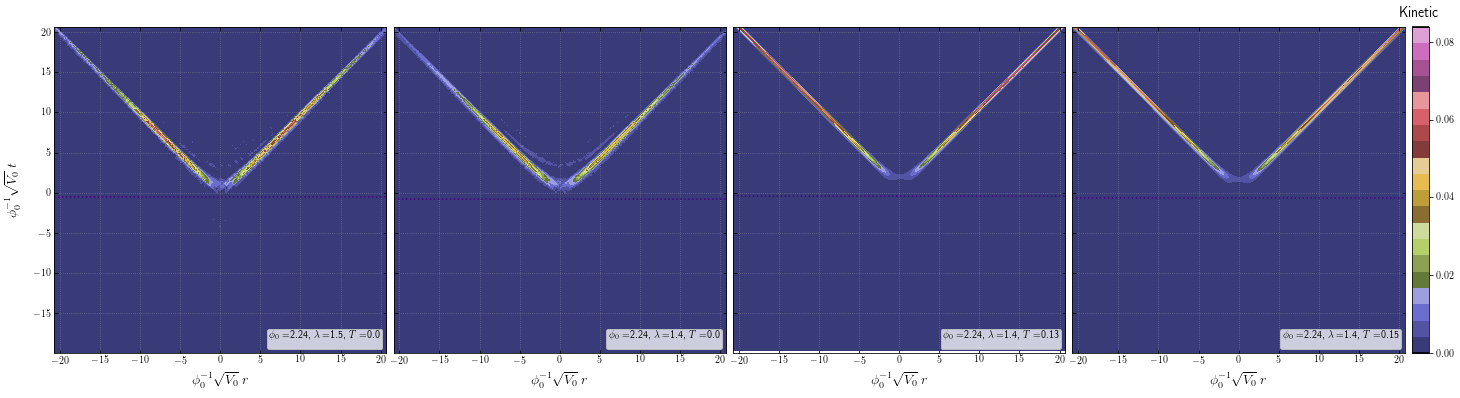

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


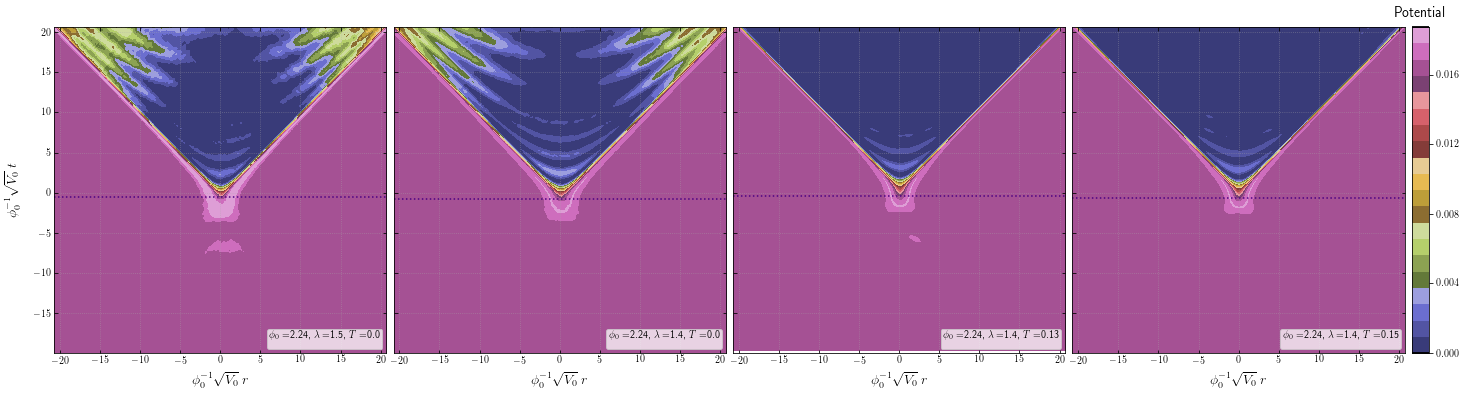

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


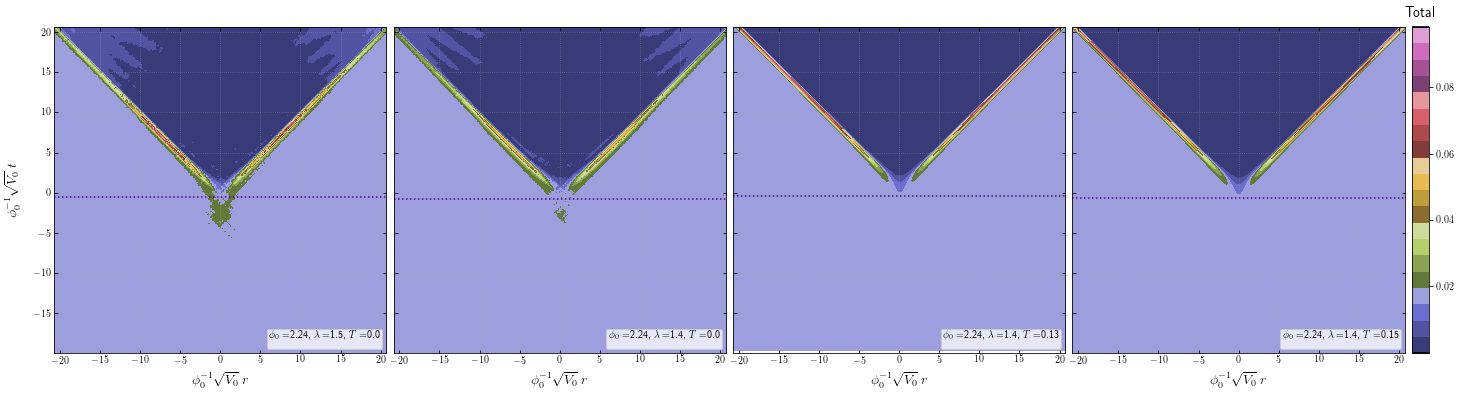

In [33]:
titls = ['Kinetic', 'Gradient', 'Potential', 'Total']
for cp in range(4):
    if cp==1: continue
    valmin, valmax = 0.015,0.015
    
    fig = plt.figure(figsize = (25, 6))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, len(bubbleList)), share_all=True, axes_pad=0.1, cbar_location="right", cbar_mode="single")
    im = [[]]*len(bubbleList)
    for ii, average_bubble in enumerate(bubbleList):
        tmp = tmpLoaded[ii]
        temp = tempList[tmp]
        lamb = lambList[tmp]

        phieq     = np.pi
        sigmafld  = fluct_stdev(lamb, phi0, temp)
        win = 300
        critSize = 30/2.

        ### Useful
        right_Vmax  = sco.minimize_scalar(Vinv, args=lamb, bounds=(np.pi, 2*np.pi), method='bounded')
        left_Vmax   = sco.minimize_scalar(Vinv, args=lamb, bounds=(0    ,   np.pi), method='bounded')
        crit_thresh = right_Vmax.x+2.*sigmafld

        kinetic   = 0.5*average_bubble[0,1]**2.
        gradient  = 0.5*average_bubble[0,2]**2.
        potential = V(average_bubble[0,0], lamb)
        totEbubble = kinetic + gradient + potential
        picks = [kinetic, gradient, potential, totEbubble]

        nT, nN = np.shape(average_bubble[0,0])
        tcen, xcen  = find_nucleation_center2(average_bubble[0,0], phieq, crit_thresh, critSize)
        tl, tr      = max(0, tcen-win), min(nT-1, tcen+win)
        xl, xr      = max(0, xcen-win), min(nN-1, xcen+win)

        bubble2plot = picks[cp]
        bubble2plot = bubble2plot[tl:tr,xl:xr]

        bubble2measure = average_bubble[0,0][tl:tr,xl:xr]
        nT, nN = np.shape(bubble2measure)
        tcen, xcen = find_nucleation_center2(bubble2measure, phieq, crit_thresh, critSize)
        ext  = np.asarray([(-xcen), (nN-xcen), (-tcen), (nT-tcen)])*dx2plot

        if np.amin(bubble2plot) < valmin: valmin = np.amin(bubble2plot)
        if np.amax(bubble2plot) > valmax: valmax, maxable = np.amax(bubble2plot), ii

        labs = r'$\phi_0=$'+str('%.2f'%phi0)+r', $\lambda=$'+str(lamb)+r', $T=$'+str(temp)
        lsl = ('-' if tmp==0 else '--' if tmp==1 else ':')

        grid[ii].legend(title=labs, loc=4, fontsize='small', fancybox=True, frameon=True, framealpha=0.75, borderpad=0.3)
        im[ii] = grid[ii].imshow(bubble2plot, interpolation='gaussian', extent=ext, origin='lower', cmap='tab20b')
        cbar = grid[ii].cax.colorbar(im[maxable])

        grid[ii].cax.toggle_label(True)
        grid[ii].cax.set_title(titls[cp])
        im[ii].set_clim(vmin=valmin, vmax=valmax)
        grid[ii].tick_params(direction='in', which='both', top=True, right=True)
        grid[ii].set(xlabel=r'$\phi_0^{-1} \sqrt{V_0} \; r$')
        grid[0].set(ylabel=r'$\phi_0^{-1} \sqrt{V_0} \; t$')

        indmin = int(indList[ii])
        grid[ii].axhline((indmin-tl+1-tcen)*dx2plot, ls=':', color='indigo')
        grid[ii].grid(ls=':', color='darkgray', alpha=0.5)
    plt.savefig('./data/average_vacuum_bubble_energies_comparison_'+str(cp)+'.pdf')
    plt.show()


Number of bubbles, temperature: 606 0.13
606 606
Number of bubbles, temperature: 857 0.15
857 857


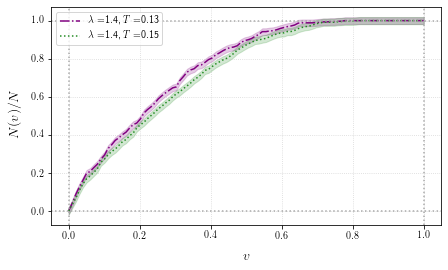

In [34]:
fig, ax = plt.subplots(1,1, figsize = (7,4))
cols = cycle(['purple', 'forestgreen', 'orange', 'blue'])
for tmp, temp in enumerate(tempList):
    
    temp = tempList[tmp]
    lamb = lambList[tmp]

    if temp==0: continue

    labs = r'$\lambda=$'+str(lamb)+r', $T=$'+str(temp)
    lsl = ('-' if tmp==0 else '--' if tmp==1 else '-.' if tmp==2 else ':')

    veldata = np.load(velocities_bubbles_file(nLat, lamb, phi0, temp)+'.npy')
    simvels, all_vels = veldata[:,0], veldata[:,1]
    print('Number of bubbles, temperature:', len(all_vels), temp)

    all_vels = np.abs(all_vels)
 #   vlist = np.linspace(-1,1,100)
    vlist = np.linspace(0.,1,100)
    fraction = [len(all_vels[all_vels<ii])/len(all_vels) for ii in vlist]

    pool = set(all_vels); print(len(pool), len(all_vels))
    nsets = 20
    setList = []
    means, vars = np.empty(nsets), np.empty(nsets)
    slen = len(pool) // nsets
    for ss in range(nsets):
        setList.append(random.sample(pool, slen))
        velssec = np.abs(setList[-1])
        vars[ss] = np.std(velssec)
        pool -= set(setList[-1])

    yerr = np.mean(vars)
    ystd = np.std(vars)**2.
    col = next(cols)
    plt.plot(vlist, fraction, label=labs, ls=lsl, color=col)
    plt.fill_between(vlist, fraction - yerr/len(vlist)**0.5, fraction + yerr/len(vlist)**0.5, color=col, alpha=0.2)

plt.axvline(0, ls=':', color='darkgray')
plt.axhline(0, ls=':', color='darkgray')
plt.axvline(1, ls=':', color='darkgray')
plt.axhline(1, ls=':', color='darkgray')
ax.grid(ls=':', color='darkgray',alpha=0.5)
plt.xlabel(r'$v$'); plt.ylabel(r'$N(v)/N$')
plt.legend(loc=2)
plt.savefig('./data/comparison_fracitons_vels.pdf'); plt.show()



In [12]:
bubbleList, instantonList, tmpLoaded, indList, eCritList = [], [], [], [], []
for tmp, temp in enumerate(tempList):
    lamb     = lambList[tmp]
    sigmafld = fluct_stdev(lamb, phi0, temp)
    pathavbub = average_bubble_file(nLat, lamb, phi0, temp)+'.npy'
    bubbleList.append(np.load(pathavbub))

    instantonList.append(np.load(path_inst(nLat, lamb, phi0, temp)+'.npy'))

    tmpLoaded.append(tmp)

    indList.append(np.load(path_indcrit(nLat, lamb, phi0, temp)+'.npy'))
    eCritList.append(np.load(path_encrit(nLat, lamb, phi0, temp)+'.npy'))    

0.2962865727212778
606 606
0.3242625005647481
857 857


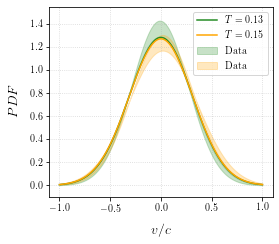

In [13]:
fig, ax = plt.subplots(1,1, figsize = (4,3.5))
cols = cycle(['purple', 'forestgreen', 'orange', 'blue'])
cols = cycle(['forestgreen', 'orange', 'blue'])
for tmp, temp in enumerate([0.13, 0.15]):

    lamb = 1.4

    col = next(cols)
    labs = r'$\phi_0=$'+str('%.2f'%phi0)+r', $\lambda=$'+str(lamb)+r', $T=$'+str(temp)
    lsl = ('--' if tmp==0 else '-' if tmp==1 else ':' if tmp==2 else '-.')

    nB = 20
    slots = np.linspace(-1., 1., nB)

    veldata = np.load(velocities_bubbles_file(nLat, lamb, phi0, temp)+'.npy')
    simvels, all_vels = veldata[:,0], veldata[:,1]

    print(np.std(all_vels))

    Eemp = np.load(path_encrit(nLat, lamb, phi0, temp)+'.npy')
    xlist = np.linspace(-1.,1.,1000)

    mu    = 0.
    sigma = (temp/Eemp)**0.5

#    ax.hist(all_vels, bins=slots, density=True, rwidth=0.8,  edgecolor='#169acf', color=col, linewidth=0.5, label='T='+str(temp))
    ax.plot(xlist, scp.stats.norm.pdf(xlist, mu, sigma), label=r'$T=%5.2f$'%(temp), ls='-', color=col)
#    ax.plot(xlist, np.exp(-((xlist - mu) ** 2) / (2 * sigma**2.)) / (np.sqrt(2 * np.pi * sigma**2.)), label='new T='+str(temp), ls='-', color=col)

    pool = set(all_vels); print(len(pool), len(all_vels))
    nsets = 7
    setList = []
    means, vars = np.empty(nsets), np.empty(nsets)
    slen = len(pool) // nsets # we need 3 subsets
    for ss in range(nsets):
        setList.append(random.sample(pool, slen))
        means[ss], vars[ss] = np.mean(setList[-1]), np.std(setList[-1])
        pool -= set(setList[-1])

    ax.fill_between(xlist, scp.stats.norm.pdf(xlist, np.mean(means), np.mean(vars)-np.std(vars)),\
                           scp.stats.norm.pdf(xlist, np.mean(means), np.mean(vars)+np.std(vars)), color=col, alpha=0.25)
    ax.fill_between(xlist, 1000, 1000, ls='-', color=col, alpha=0.25, label=r'$\rm Data$')
ax.legend()
ax.grid(ls=':', color='darkgray',alpha=0.5)
ax.set_ylim((-0.1, 1.55))
ax.set_xlabel(r'$v/c$'); ax.set_ylabel(r'$PDF$')
plt.savefig('./data/comparison_vels_PDF.pdf'); plt.show()


0.8026885509262544
388 388
0.7835363754019584
1154 1154


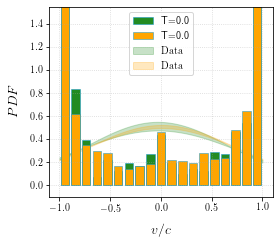

In [25]:
fig, ax = plt.subplots(1,1, figsize = (4,3.5))
cols = cycle(['purple', 'forestgreen', 'orange', 'blue'])
cols = cycle(['forestgreen', 'orange', 'blue'])
for tmp, temp in enumerate(tempList):

    temp = tempList[tmp]
    lamb = lambList[tmp]
    
    if temp!=0: continue

    col = next(cols)
    labs = r'$\phi_0=$'+str('%.2f'%phi0)+r', $\lambda=$'+str(lamb)+r', $T=$'+str(temp)
    lsl = ('--' if tmp==0 else '-' if tmp==1 else ':' if tmp==2 else '-.')

    nB = 20
    slots = np.linspace(-1., 1., nB)

    veldata = np.load(velocities_bubbles_file(nLat, lamb, phi0, temp)+'.npy')
    simvels, all_vels = veldata[:,0], veldata[:,1]

    print(np.std(all_vels))

    Eemp = np.load(path_encrit(nLat, lamb, phi0, temp)+'.npy')
    xlist = np.linspace(-1.,1.,1000)

    mu    = 0.
    sigma = (temp/Eemp)**0.5

    ax.hist(all_vels, bins=slots, density=True, rwidth=0.8,  edgecolor='#169acf', color=col, linewidth=0.5, label='T='+str(temp))
#    ax.plot(xlist, scp.stats.norm.pdf(xlist, mu, sigma), label=r'$T=%5.2f$'%(temp), ls='-', color=col)
#    ax.plot(xlist, np.exp(-((xlist - mu) ** 2) / (2 * sigma**2.)) / (np.sqrt(2 * np.pi * sigma**2.)), label='new T='+str(temp), ls='-', color=col)

    pool = set(all_vels); print(len(pool), len(all_vels))
    nsets = 7
    setList = []
    means, vars = np.empty(nsets), np.empty(nsets)
    slen = len(pool) // nsets # we need 3 subsets
    for ss in range(nsets):
        setList.append(random.sample(pool, slen))
        means[ss], vars[ss] = np.mean(setList[-1]), np.std(setList[-1])
        pool -= set(setList[-1])

    ax.fill_between(xlist, scp.stats.norm.pdf(xlist, np.mean(means), np.mean(vars)-np.std(vars)),\
                           scp.stats.norm.pdf(xlist, np.mean(means), np.mean(vars)+np.std(vars)), color=col, alpha=0.25)
    ax.fill_between(xlist, 1000, 1000, ls='-', color=col, alpha=0.25, label=r'$\rm Data$')
ax.legend()
ax.grid(ls=':', color='darkgray',alpha=0.5)
ax.set_ylim((-0.1, 1.55))
ax.set_xlabel(r'$v/c$'); ax.set_ylabel(r'$PDF$')
plt.savefig('./data/comparison_vels_PDF.pdf'); plt.show()


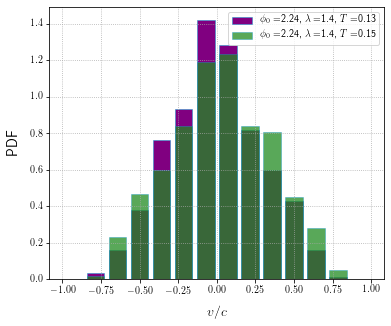

In [15]:
fig, ax = plt.subplots(1,1, figsize = (6,5))
cols = cycle(['purple', 'forestgreen', 'orange', 'blue'])
for tmp, temp in enumerate(tempList):
   # if tmp==0 or tmp==3: continue
    if temp==0: continue

    temp = tempList[tmp]
    lamb = lambList[tmp]

    col = next(cols)
    veldata = np.load(velocities_bubbles_file(nLat, lamb, phi0, temp)+'.npy')
    simvels, all_vels = veldata[:,0], veldata[:,1]

    labs = r'$\phi_0=$'+str('%.2f'%phi0)+r', $\lambda=$'+str(lamb)+r', $T=$'+str(temp)
    lsl = ('--' if tmp==0 else '-' if tmp==1 else ':' if tmp==2 else '-.')

    nB = 15
    allist = [0.75, 1., 0.75, 1.][::-1]
    slots = np.linspace(-1., 1., nB)
    ax.hist(all_vels, bins=slots, density=True, rwidth=0.8,  edgecolor='#169acf', linewidth=0.5, alpha=allist[tmp], color=col, label=labs)

    ax.legend(); ax.grid(ls=':', color='darkgray')
    ax.set_xlabel(r'$v/c$'); ax.set_ylabel(r'PDF')
plt.savefig('./data/histograms_vels_lamb.pdf')
plt.show()


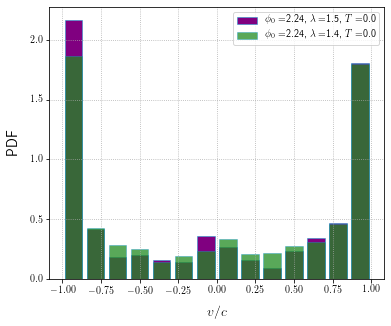

In [16]:
fig, ax = plt.subplots(1,1, figsize = (6,5))
#plt.style.use('seaborn-whitegrid') # nice and clean grid
cols = cycle(['purple', 'forestgreen', 'orange', 'blue'])
#cols=cycle(['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226'])
for tmp, temp in enumerate(tempList):
    if tmp==2 or tmp==3: continue

    temp = tempList[tmp]
    lamb = lambList[tmp]

    col = next(cols)
    veldata = np.load(velocities_bubbles_file(nLat, lamb, phi0, temp)+'.npy')
    simvels, all_vels = veldata[:,0], veldata[:,1]

    labs = r'$\phi_0=$'+str('%.2f'%phi0)+r', $\lambda=$'+str(lamb)+r', $T=$'+str(temp)
    lsl = ('--' if tmp==0 else '-' if tmp==1 else ':' if tmp==2 else '-.')

    nB = 15
    allist = [1., 0.75, 0.75, 1.]
    slots = np.linspace(-1., 1., nB)
    ax.hist(all_vels, bins=slots, density=True, rwidth=0.8,  edgecolor='#169acf', linewidth=0.5, alpha=allist[tmp], color=col, label=labs)

    ax.legend(); ax.grid(ls=':', color='darkgray')
    ax.set_xlabel(r'$v/c$'); ax.set_ylabel(r'PDF')
plt.savefig('./data/histograms_vels_lamb.pdf')
plt.show()


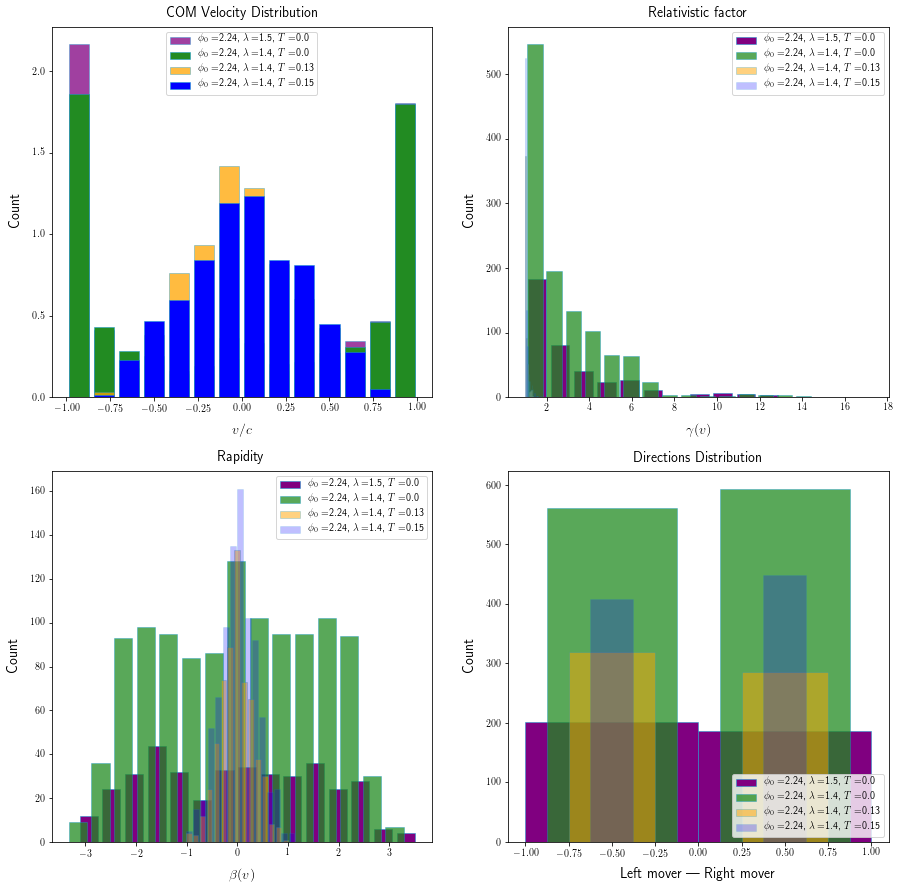

In [17]:
fig, ax = plt.subplots(2,2, figsize = (15,15))
#plt.style.use('seaborn-whitegrid') # nice and clean grid
cols = cycle(['purple', 'forestgreen', 'orange', 'blue'])
#cols=cycle(['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226'])
for tmp, temp in enumerate(tempList):
    temp = tempList[tmp]
    lamb = lambList[tmp]

    col = next(cols)
    veldata = np.load(velocities_bubbles_file(nLat, lamb, phi0, temp)+'.npy')
    simvels, all_vels = veldata[:,0], veldata[:,1]

    labs = r'$\phi_0=$'+str('%.2f'%phi0)+r', $\lambda=$'+str(lamb)+r', $T=$'+str(temp)
    lsl = ('-' if tmp==0 else '--' if tmp==1 else '-.' if tmp==2 else ':')

    nB = 15
    allist = [0.75, 1., 0.75, 1.]
    slots = np.linspace(-1., 1., nB)
    ax[0,0].hist(all_vels, bins=slots, density=True, rwidth=0.8,  edgecolor='#169acf', linewidth=0.5, alpha=allist[tmp], color=col, label=labs)
    ax[0,0].set_title('COM Velocity Distribution')
    ax[0,0].set_xlabel(r'$v/c$')

    ax[0,1].hist(gamma(all_vels), bins=nB, density=False, rwidth=0.8,  edgecolor='#169acf', linewidth=0.5, alpha=1-tmp*0.25, color=col, label=labs)
    ax[0,1].set_title('Relativistic factor')
    ax[0,1].set_xlabel(r'$\gamma(v)$')

    ax[1,0].hist(rapidity(all_vels), bins=nB, density=False, rwidth=0.8,  edgecolor='#169acf', linewidth=0.5, alpha=1-tmp*0.25, color=col, label=labs)
    ax[1,0].set_title('Rapidity')
    ax[1,0].set_xlabel(r'$\beta(v)$')

    ax[1,1].hist(np.sign(all_vels), bins=2, density=False, rwidth=1-tmp*0.25,  edgecolor='#169acf', linewidth=0.5, alpha=1-tmp*0.25, color=col, label=labs)
    ax[1,1].set_title('Directions Distribution')
    ax[1,1].set_xlabel(r' Left mover | Right mover ')

    for xx, axx in enumerate(ax.flatten()):
        axx.set_ylabel('Count')
        axx.legend(loc=('upper center', 'upper right', 'upper right', 'lower right')[xx])
plt.savefig('./data/histograms_vels_lamb.pdf')
plt.show()


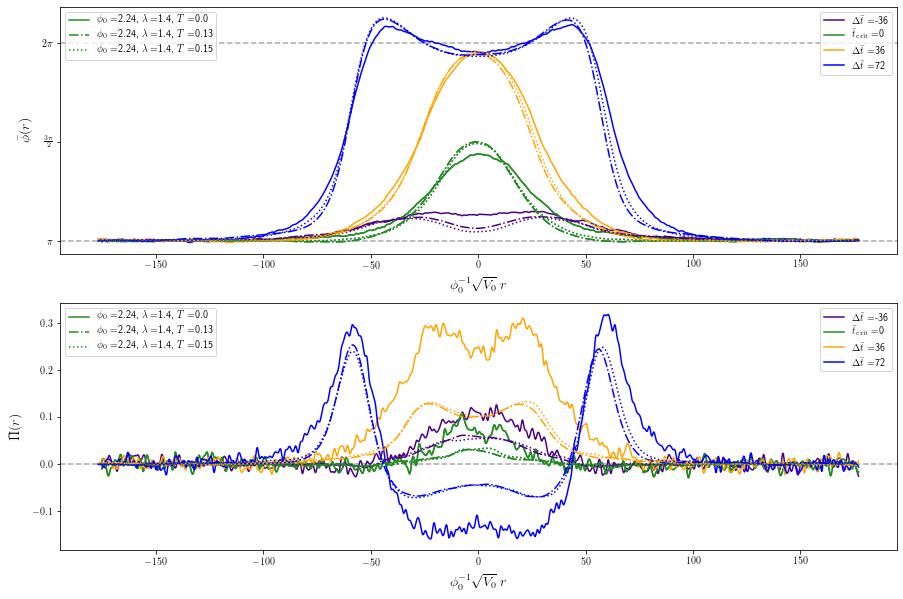

In [18]:
fig, ax = plt.subplots(2, 1, figsize = (15, 10))
ax[1].axhline(0., color='darkgray', ls='--')
ax[0].axhline(phieq, color='darkgray', ls='--')
ax[0].axhline(2.*np.pi, color='darkgray', ls='--') 
ax[0].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

for coln in [0,1]:
    bool = True
    secondary_lines, secondary_labels = [], []
    cols = cycle(['indigo', 'forestgreen', 'orange', 'blue'])
    for ii, average_bubble in enumerate(bubbleList):
        indmin = int(indList[ii])
        tmp = tmpLoaded[ii]
        if tmp==0: continue
        temp = tempList[tmp]
        lamb = lambList[tmp]

        timesList = np.arange(indmin-9*4, indmin+18*4+1, 9*4).tolist()
        timesList = np.sort(np.asarray(timesList))

        xcen = (np.argmax(average_bubble[0,0][indmin,:])+1)

        labs = r'$\phi_0=$'+str('%.2f'%phi0)+r', $\lambda=$'+str(lamb)+r', $T=$'+str(temp)
        lsl = ('-' if tmp==1 else '--' if tmp==0 else '-.' if tmp==2 else ':')
        for tt in timesList:
           # col = (cols[ii] if tt!=indmin else 'k')
            col = next(cols)
            xmin   = 125
            data   = average_bubble[0,coln,tt,xmin:-xmin+1]
            xlist  = np.linspace(xmin, len(data)+xmin, len(data))
            xlist  = xlist - xcen

            spline  = scp.interpolate.splrep(xlist, data)
            r       = np.linspace(xlist[0], xlist[-1], 2000)
            profile = scp.interpolate.splev(r, spline)

            if tt == indmin:
                secondary_labels.append(labs)
                l1, = ax[coln].plot(r, profile, color=col, ls=lsl)
                secondary_lines.append(l1)

            if bool:
                ax[coln].plot(r, profile, color=col, ls=lsl, label=(r'$\Delta \bar{t} = $'+str(tt-indmin) if tt!=indmin else r'$\bar{t}_{\rm crit} = $'+str(tt-indmin)))
            else:
                ax[coln].plot(r, profile, color=col, ls=lsl)

        bool = False
    ax[coln].add_artist(ax[coln].legend(secondary_lines, secondary_labels, loc=2))
    
ax[0].set_ylabel(r'$\bar{\phi}(r)$')
ax[1].set_ylabel(r'$\bar{\Pi}(r)$')
for axx in ax.flatten():
    axx.set_xlabel(r'$\phi_0^{-1} \sqrt{V_0} \; r$')
    axx.legend(loc=1)
    axx.grid(False)
plt.savefig('./data/profile_comparison_thermal.pdf')
plt.show()
